## TimeSeries Model for Alberta Download Speed

### 1. Packages

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns 
%matplotlib inline 

### 2. Reading Files

In [96]:
AB_df = pd.read_csv('../data/model_data/Alberta_Speed_Data_Grouped.csv')

In [97]:
AB_df.head()

,avg_d_kbps
0,64501.807089
1,65839.564439
2,69426.308808
3,71961.254161
4,73054.660884


In [98]:
AB_df.shape

(17, 1)

### 3. Plotting Data

In [99]:
time_index = pd.date_range(start='2019-Q1', end='2023-Q2', freq='Q')
AB_df.set_index(time_index, inplace=True)

In [100]:
AB_df = AB_df.to_period('Q')
AB_df

,avg_d_kbps
2019Q1,64501.807089
2019Q2,65839.564439
2019Q3,69426.308808
2019Q4,71961.254161
2020Q1,73054.660884
2020Q2,70591.225705
2020Q3,77523.109218
2020Q4,87178.815007
2021Q1,87970.058126
2021Q2,101021.247794


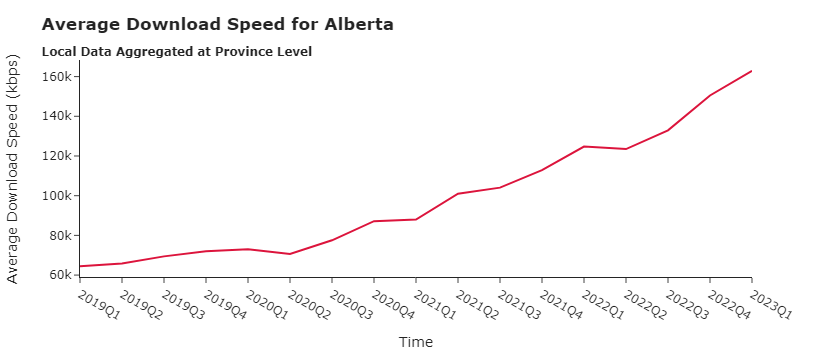

In [101]:
import plotly.express as px

AB_plot_df = AB_df.copy()
AB_plot_df = AB_plot_df.reset_index()
AB_plot_df['index'] = AB_plot_df['index'].astype(str)

fig = px.line(AB_plot_df,
              x = 'index',
              template = 'simple_white',
              color_discrete_sequence=['crimson'],
              y = 'avg_d_kbps')
fig.update_layout(title='<b>Average Download Speed for Alberta<b><br><sub>Local Data Aggregated at Province Level<sub>', 
                  xaxis_title='Time', 
                  yaxis_title='Average Download Speed (kbps)')

fig.show()

Average Download Speed of Alberta seems to have an increasing trend which is well expected. However, there seems no apparent seasonal component inside the time series. 

### 4. AutoCorrelation Plots (ACF and PACF)

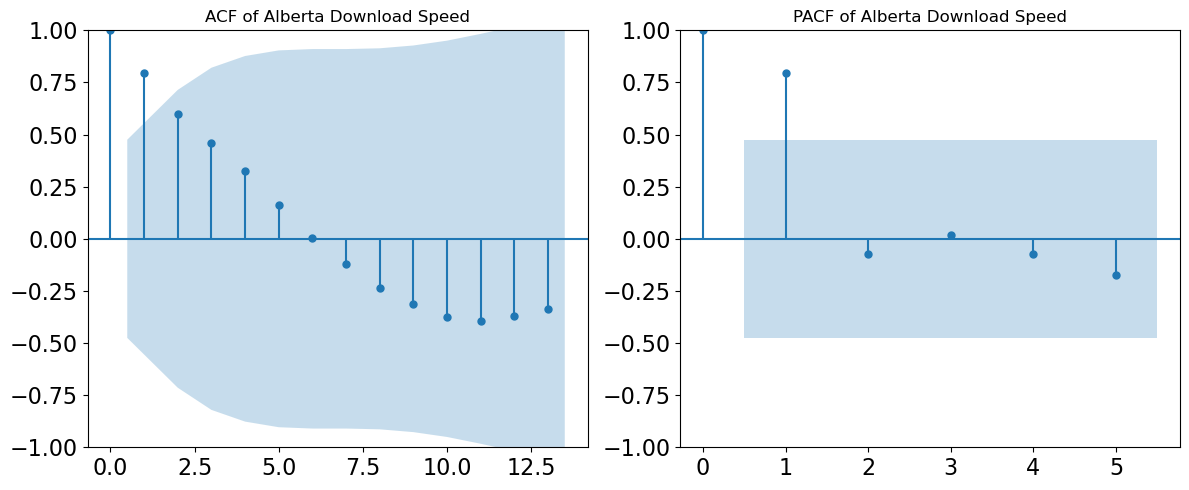

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(AB_df['avg_d_kbps'],
         title='ACF of Alberta Download Speed',
         ax = ax1)
plot_pacf(AB_df['avg_d_kbps'],
          title='PACF of Alberta Download Speed',
          lags = 5,
          ax = ax2)
plt.tight_layout()
plt.show()

While ACF shows a clear decay in the autocorrelation of lags, PACF displays an obvious cut off after lag 1. This properties indicate that Average Download Speed of Alberta is an AR(1) process. 

### 5. Stationarity Checks
As shown in the time series plot, Alberta Download Speed dataset has a trend and trend indicates that dataset is not stationary (i.e. mean and / or variance are not constant through time). However, it's better to use a statistical test to check for stationarity.

In this part, Augmented Dickey-Fuller Test is required to test for stationarity with following Hypothesis.

**$$
H_0: \text{Time Series Data is NOT stationary.}\\
H_A: \text{Time Series Data is stationary.}
$$**

In [103]:
result = adfuller(AB_df['avg_d_kbps'])
print(f'ADF Statistic: {result[0]:.2f} and the p-value: {result[1]}')
if result[1] < 0.05:
    print('Need to Reject Null Hypothesis. Time Series Data is stationary')
else:
    print('Failed to Reject Null Hypothesis. Time Series Data is NOT stationary')

ADF Statistic: 2.81 and the p-value: 1.0
Failed to Reject Null Hypothesis. Time Series Data is NOT stationary


The time series data, as discussed above, is not stationary and it requires differencing or other methods to deal with it. 

### 6. Time Series Decomposition

Text(0.5, 0.98, 'Alberta Download Speed Decomposition')

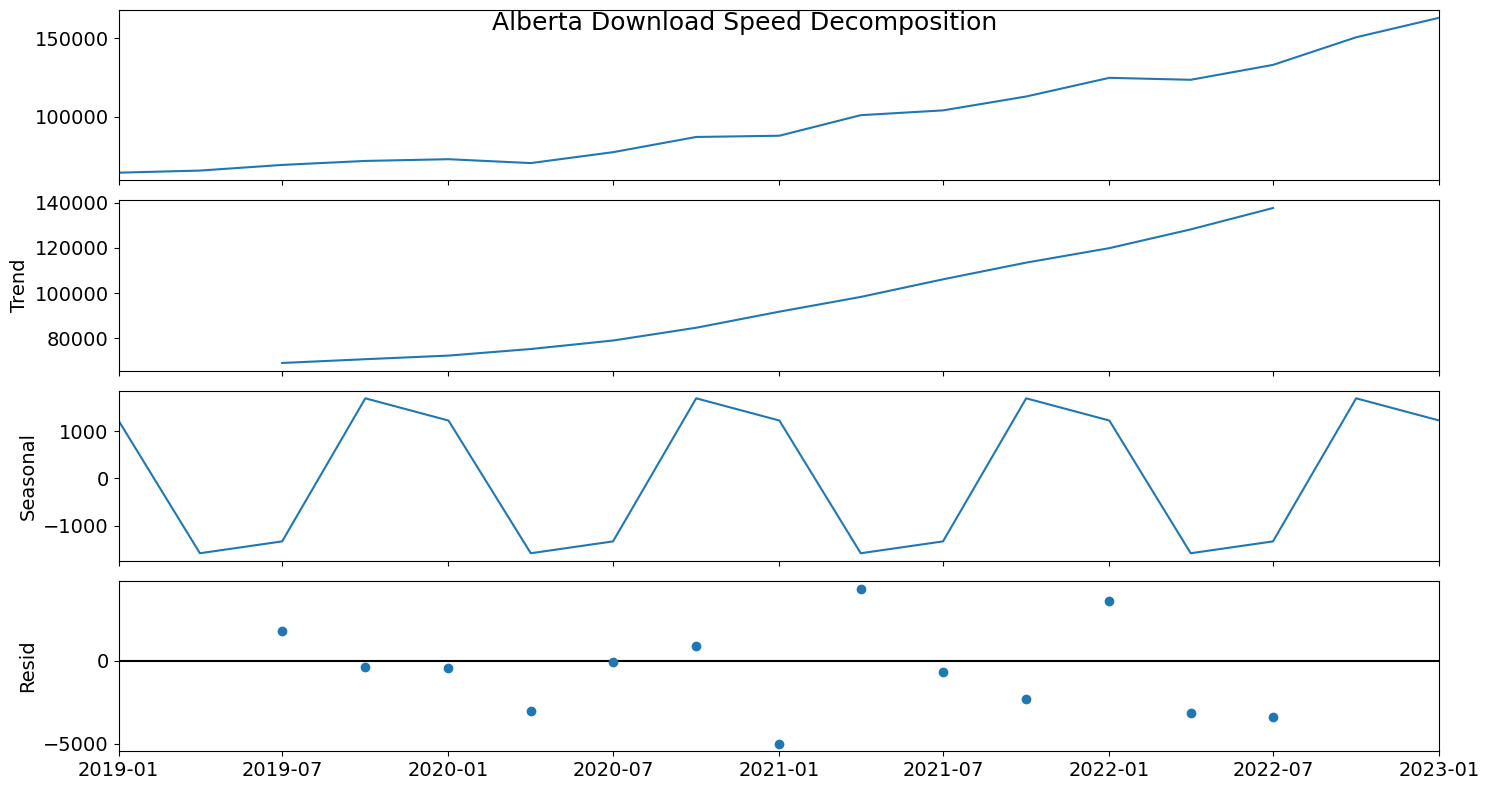

In [111]:
from pylab import rcParams
AB_dec_df = AB_df.copy()
AB_dec_df.index = pd.to_datetime(AB_df.index.to_timestamp(), format='%Y-%m-%d').to_period('Q').to_timestamp()
rcParams['figure.figsize'] = 15, 8
rcParams['axes.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['xtick.labelsize'] = 14
decomposition = sm.tsa.seasonal_decompose(AB_dec_df, model='additive')
decomp = decomposition.plot()
decomp.suptitle('Alberta Download Speed Decomposition', fontsize=18)

Above plots shows the trend and seasonal component of Alberta Download Speed dataset.

### 7. Differencing

First Order Differencing

In [133]:
diff_df = pd.DataFrame(AB_df['avg_d_kbps'].diff())
diff_df.dropna(inplace=True)

result = adfuller(diff_df['avg_d_kbps'])
print(f'ADF Statistic: {result[0]:.2f} and the p-value: {result[1]}')
if result[1] < 0.05:
    print('Need to Reject Null Hypothesis. Time Series Data is stationary')
else:
    print('Failed to Reject Null Hypothesis. Time Series Data is NOT stationary')

ADF Statistic: -3.16 and the p-value: 0.022294514063288928
Need to Reject Null Hypothesis. Time Series Data is stationary


Differencing the time series data ensured that it is stationary.

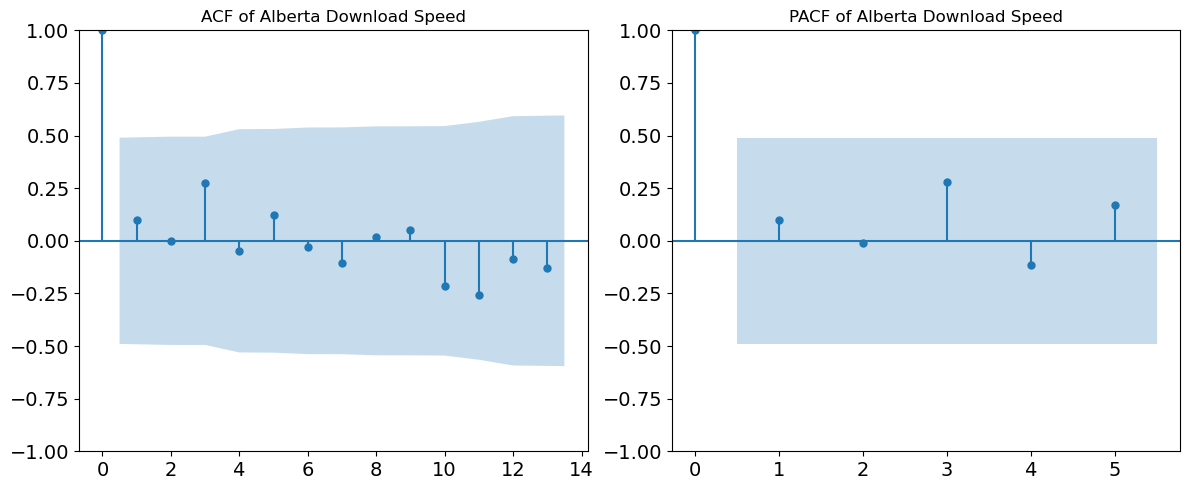

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(diff_df['avg_d_kbps'],
         title='ACF of Alberta Download Speed',
         ax = ax1)
plot_pacf(diff_df['avg_d_kbps'],
          title='PACF of Alberta Download Speed',
          lags = 5,
          ax = ax2)
plt.tight_layout()
plt.show()

By differencing the dataset, ACF and PACF do not display any spikes in any lags. Therefore, it's not appropriate to use ARIMA model to forecast future values of Alberta Download Speed.

### 7. Alternative Model Building